In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import numpy as np
import sys
from pyinstrument import Profiler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from bart_playground import *
import bartz

In [3]:
proposal_probs = {"grow" : 0.4,
                  "prune" : 0.4,
                  "change" : 0.1,
                  "swap" : 0.1}
generator = DataGenerator(n_samples=160, n_features=2, noise=0.1, random_seed=42)
X, y = generator.generate(scenario="piecewise_flat")
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
np.set_printoptions(suppress=True)
print(y_train[:12])

[ 0.50327821  0.60672224  0.26898966  0.55211673  0.50693811  0.66162097
 -0.64127659  0.65112284  0.03487759  0.23276531  0.44055996  0.38216964]


In [4]:
bart = DefaultBART(ndpost=1000, nskip=1000, n_trees=60, proposal_probs=proposal_probs)
bart.fit(X_train, y_train)

Iterations: 100%|██████████| 2000/2000 [00:23<00:00, 84.94it/s] 


In [5]:
arrays = [tree.vars for tree in bart.trace[-1].trees]
counts = np.array([np.count_nonzero(arr >= 0) for arr in arrays])
print(counts)
deep_trees = np.array([count >= 3 for count in counts])
print(np.where(deep_trees))

[3 1 1 1 1 1 2 1 2 1 3 2 3 2 2 1 1 1 1 1 1 0 1 4 2 1 3 1 2 0 1 1 2 2 1 1 2
 2 1 1 1 1 2 2 1 2 2 4 1 2 2 1 3 3 5 2 2 3 2 2]
(array([ 0, 10, 12, 23, 26, 47, 52, 53, 54, 57], dtype=int64),)


In [6]:
bart.sampler.trace[-1].trees

[Tree(vars=[ 0  0  1 -1 -1 -1 -1 -2], thresholds=[0.16394061 0.12731028 0.51179255        nan        nan        nan
         nan        nan], leaf_vals=[        nan         nan         nan  0.01242781 -0.02576158  0.00776542
  -0.00623299         nan], n_vals=[120  24  96  18   6  49  47  -2]),
 Tree(vars=[ 0 -1 -1 -2], thresholds=[0.59333154        nan        nan        nan], leaf_vals=[       nan 0.02675468 0.00049891        nan], n_vals=[120  77  43  -2]),
 Tree(vars=[ 1 -1 -1 -2], thresholds=[0.22963186        nan        nan        nan], leaf_vals=[        nan -0.00805255 -0.03174421         nan], n_vals=[120  25  95  -2]),
 Tree(vars=[ 1 -1 -1 -2], thresholds=[0.25855578        nan        nan        nan], leaf_vals=[        nan -0.05835472  0.00671018         nan], n_vals=[120  29  91  -2]),
 Tree(vars=[ 0 -1 -1 -2], thresholds=[0.21091556        nan        nan        nan], leaf_vals=[       nan 0.00828108 0.00822814        nan], n_vals=[120  30  90  -2]),
 Tree(vars=[ 0 -1 -1 -2]

In [7]:
rf = RandomForestRegressor(random_state=42)
lr = LinearRegression()
rf.fit(X_train, y_train)
lr.fit(X_train, y_train)

btz = bartz.BART.gbart(np.transpose(X_train), y_train, ntree=60, ndpost=200, nskip=100)
btpred_all = btz.predict(np.transpose(X_test))
btpred = np.mean(np.array(btpred_all), axis=0)

INFO:2025-04-15 01:14:17,251:jax._src.xla_bridge:927: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-04-15 01:14:17,254:jax._src.xla_bridge:927: Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.


Iteration 100/300 P_grow=0.48 P_prune=0.52 A_grow=0.28 A_prune=0.32 (burnin)
Iteration 200/300 P_grow=0.67 P_prune=0.33 A_grow=0.22 A_prune=0.20
Iteration 300/300 P_grow=0.60 P_prune=0.40 A_grow=0.14 A_prune=0.25


In [8]:
models = {"bart" : bart, 
          "rf" : rf, 
          "lr" : lr,
          "btz" : btz}
results = {}
for model_name, model in models.items():
    if model_name == "btz":
        results[model_name] = mean_squared_error(y_test, btpred)
    else:
        results[model_name] = mean_squared_error(y_test, model.predict(X_test))
results

{'bart': 0.022315103216828634,
 'rf': 0.022139023845392215,
 'lr': 0.048045521328019404,
 'btz': 0.022310167481946662}

In [9]:
X_sample = X_test[0].reshape(1, -1)
y_test[0]

0.574943389972774

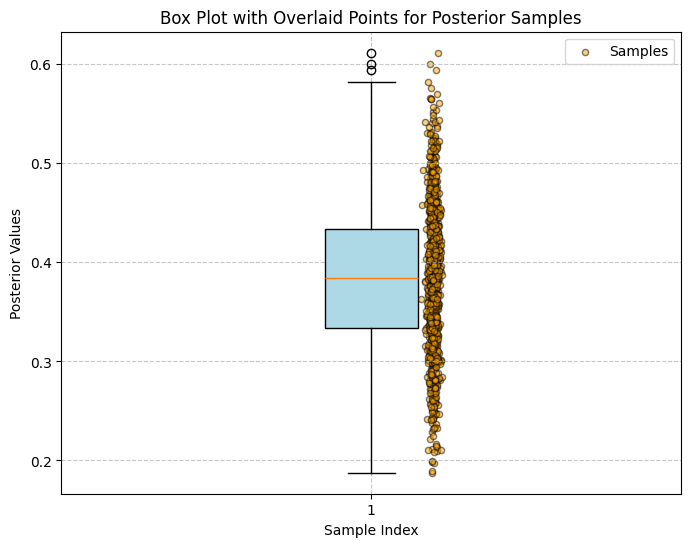

In [10]:
import matplotlib.pyplot as plt
import numpy as np

posterior_values = bart.posterior_f(X_sample)

plt.figure(figsize=(8, 6))
plt.boxplot(posterior_values[0], vert=True, patch_artist=True, boxprops=dict(facecolor='lightblue'))
for i in range(posterior_values.shape[1]):
    y = posterior_values[:, i]
    x = np.random.normal(1.1, 0.005, size=len(y))
    plt.scatter(x, y, alpha=0.5, color='orange', edgecolor='k', s=20, label='Samples' if i == 0 else None)

plt.title('Box Plot with Overlaid Points for Posterior Samples')
plt.ylabel('Posterior Values')
plt.xlabel('Sample Index')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

In [11]:
eval_single = [float(bart.trace[0].trees[i].evaluate(X_sample)) for i in range(len(bart.trace[0].trees))]
eval_single

[0.07584665233738307,
 -0.00986419673745097,
 -0.05457090407725808,
 -0.023476531600058487,
 0.005106370205276481,
 -0.016645731163648616,
 0.0011827670337743695,
 0.036746127747280685,
 0.03067783192180116,
 -0.003357838271691907,
 0.04138408144685778,
 0.015964842874283174,
 0.023916594579341706,
 -0.0016215935907991086,
 0.017832487665100052,
 0.0006880911259770821,
 -0.009455999359196148,
 0.007654515228144662,
 0.02212157240498582,
 -0.041014940137712536,
 0.0011646321522059471,
 -0.004050882007090694,
 0.03587332697161719,
 -0.019709860013731123,
 0.027373372564751926,
 0.06957476706191683,
 -0.003899599804502745,
 0.08831578556500877,
 -0.016608101667854005,
 0.03642708115576807,
 0.0037954460313930592,
 -0.056158790692443915,
 0.034019519593751796,
 -0.0428975708138376,
 0.03353273580749335,
 0.06682188685005169,
 -0.044998091820255035,
 0.0007400436276770549,
 0.044619956790850165,
 0.03453534806836932,
 0.040158124094544737,
 0.016056128541627714,
 -0.04963075279755,
 -0.0437

In [12]:
len(eval_single)

60

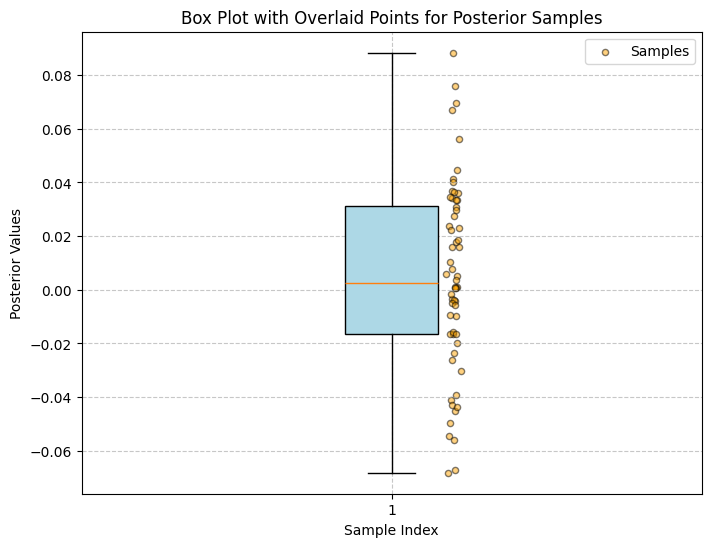

In [13]:
plt.figure(figsize=(8, 6))
plt.boxplot(eval_single, vert=True, patch_artist=True, boxprops=dict(facecolor='lightblue'))
for i in range(len(eval_single)):
    y = eval_single[i]
    x = np.random.normal(1.1, 0.005, size=1)
    plt.scatter(x, y, alpha=0.5, color='orange', edgecolor='k', s=20, label='Samples' if i == 0 else None)

plt.title('Box Plot with Overlaid Points for Posterior Samples')
plt.ylabel('Posterior Values')
plt.xlabel('Sample Index')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

In [14]:
np.sum(eval_single)

0.27267143010379935

In [15]:
eval = [bart.trace[i].evaluate(X_sample) for i in range(len(bart.trace))]
eval

[array([0.27267143]),
 array([0.26998101]),
 array([0.30551949]),
 array([0.2871426]),
 array([0.26593342]),
 array([0.28945558]),
 array([0.26446808]),
 array([0.29125826]),
 array([0.21121277]),
 array([0.20036252]),
 array([0.24866607]),
 array([0.2415729]),
 array([0.2652621]),
 array([0.2491413]),
 array([0.18285223]),
 array([0.31602799]),
 array([0.32857888]),
 array([0.28029702]),
 array([0.2937967]),
 array([0.30630718]),
 array([0.34268571]),
 array([0.27099575]),
 array([0.2120259]),
 array([0.30873225]),
 array([0.28305657]),
 array([0.29649347]),
 array([0.27993412]),
 array([0.28916405]),
 array([0.30736344]),
 array([0.25805842]),
 array([0.33193382]),
 array([0.3173383]),
 array([0.26940586]),
 array([0.21257789]),
 array([0.15617436]),
 array([0.1674593]),
 array([0.2643617]),
 array([0.27419703]),
 array([0.31052748]),
 array([0.26116278]),
 array([0.27658067]),
 array([0.18481291]),
 array([0.20359122]),
 array([0.22578105]),
 array([0.25319614]),
 array([0.22488175]

In [16]:
y_test

array([ 0.57494339, -0.39107825,  0.03833771, -0.10585361,  0.58205285,
       -0.46879905, -0.12964723,  0.48524713,  0.30069396,  0.48688625,
        0.49330468,  0.4528224 ,  0.5750869 ,  0.55541165,  0.43010696,
        0.6155312 ,  0.44660998,  0.51601906,  0.48824578,  0.18206462,
        0.37483528, -0.15720403,  0.57823503,  0.43025762,  0.56087615,
        0.49741372, -0.02658388,  0.4874991 ,  0.04278904, -0.06782644,
       -0.03427862,  0.54396366,  0.52023062, -0.14805365,  0.61774119,
        0.54746971,  0.58137637, -0.46316434,  0.29964777,  0.55300647])

In [17]:
bart.predict(X_test)

array([ 0.38455441, -0.34428114,  0.07130282,  0.2166869 ,  0.57225062,
       -0.34610731,  0.23805195,  0.61399579,  0.56131115,  0.43782007,
        0.39066628,  0.64696339,  0.55160306,  0.42889943,  0.37770167,
        0.46951136,  0.55876037,  0.52653447,  0.46248185,  0.30267819,
        0.49966491,  0.10765106,  0.49766983,  0.49098124,  0.48406651,
        0.47383034, -0.33108244,  0.4556534 ,  0.05820923,  0.1210292 ,
        0.01763466,  0.39274161,  0.41870811,  0.04868854,  0.55160103,
        0.43931773,  0.4075794 , -0.49191386,  0.49203444,  0.48709512])

In [18]:
bart.posterior_f(X_test)

array([[ 0.39945947,  0.39581149,  0.4439987 , ...,  0.46290294,
         0.43663042,  0.42456575],
       [-0.38321903, -0.42491305, -0.42156821, ..., -0.42448267,
        -0.36488224, -0.47436966],
       [ 0.23683409,  0.24425158,  0.19193317, ..., -0.01242343,
         0.04087156, -0.10752977],
       ...,
       [-0.36317493, -0.49539239, -0.60075766, ..., -0.4733543 ,
        -0.36567924, -0.46229201],
       [ 0.46881114,  0.50539436,  0.41335171, ...,  0.50402813,
         0.46669609,  0.50945793],
       [ 0.45648458,  0.59309987,  0.55929472, ...,  0.52295456,
         0.52661047,  0.63437754]])

In [19]:
print(bart.sampler.trace[-1].evaluate(X_train)[:12])
print(bart.preprocessor.transform_y(y_train)[:12])

[ 0.32701212  0.35949059  0.26511881  0.33221768  0.43119771  0.3649026
 -0.50264633  0.44533097 -0.16678399  0.02468806  0.11371155  0.36416392]
[ 0.34923863  0.42552948  0.17644883  0.38525745  0.35193784  0.46601776
 -0.49488025  0.4582753   0.0037892   0.14973307  0.30298339  0.25992003]


In [20]:
mean_squared_error(y_test, np.ones_like(y_test) * y_test.mean())

0.10534048469161521